# **My name is Yahia Mohamed Nabil,**
***This notebook is for slash's AI internship***
I used a public dataset similar to what the problem you've gave to me which is fashion product images classification, There's many approaches I can solve this problem with but I decided to go with (**CNN**) as they can learn and extract features from raw pixel data without any preprocessing or feature engineering.

# **First we setup our system and import all the important libraries**

In [1]:
# essential libraries
import numpy as np
import pandas as pd

#visualization libraries
import seaborn as sns
from matplotlib import pyplot as plt

# ML/DL libraries
import tensorflow as tf
from tensorflow.keras import layers
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import math
import os
from joblib import Parallel, delayed
from PIL import Image
import warnings
warnings.filterwarnings("ignore")

print("done importing")

2024-03-14 19:11:02.437747: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-14 19:11:02.437875: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-14 19:11:02.586264: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


done importing


# **Reading the data from the csv file**

In [2]:
import csv

styles_path = "/kaggle/input/fashion-product-images-dataset/fashion-dataset/styles.csv"

with open(styles_path, 'r') as f:
    reader = csv.reader(f)
    columns = next(reader)
    rows = [row for row in reader if len(row) == len(columns)]

stylesData = pd.DataFrame(rows, columns=columns)
stylesData.head()
#where id is the image name

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011,Casual,Turtle Check Men Navy Blue Shirt
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012,Casual,Peter England Men Party Blue Jeans
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016,Casual,Titan Women Silver Watch
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011,Casual,Manchester United Men Solid Black Track Pants
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012,Casual,Puma Men Grey T-shirt


# **Droping features that are not important to our classification problem**

In [3]:
#removing all the non-important features to reduce complixety
stylesData.drop(
    ['gender', 'articleType', 'baseColour', 'season', 'year', 'usage', 'productDisplayName','subCategory'],
    axis = 1,
    inplace = True
)
stylesData.rename(columns={'masterCategory': 'target'}, inplace=True)
stylesData.head()

,id,target
0,15970,Apparel
1,39386,Apparel
2,59263,Accessories
3,21379,Apparel
4,53759,Apparel


# **Constants section**

In [4]:
#some important constants to be used in this project
NUM_CORES = os.cpu_count()
NUMBER_UNIQUE_CATEGORY = stylesData['target'].nunique()
BATCH_SIZE = 32
SCALING_SIZE = (64, 64)
SEED_VALUE = 42

# **Gain some important measures from the data**

In [5]:
# Get unique classes
unique_classes = stylesData['target'].unique()
print("Unique classes:", unique_classes)

# Get count of items under each class
class_counts = stylesData['target'].value_counts()
print("Count of items under each class:\n", class_counts)

Unique classes: ['Apparel' 'Accessories' 'Footwear' 'Personal Care' 'Free Items'
 'Sporting Goods' 'Home']
Count of items under each class:
 target
Apparel           21397
Accessories       11274
Footwear           9219
Personal Care      2403
Free Items          105
Sporting Goods       25
Home                  1
Name: count, dtype: int64


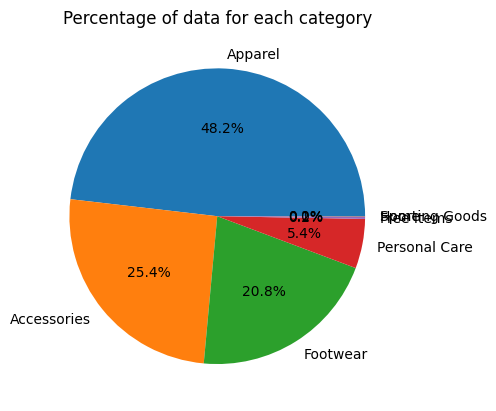

this are the percentages for being clear
target
Apparel           48.165406
Accessories       25.378174
Footwear          20.752296
Personal Care      5.409238
Free Items         0.236359
Sporting Goods     0.056276
Home               0.002251
Name: proportion, dtype: float64


In [6]:
# Calculate the percentage of each category
category_percentage = stylesData['target'].value_counts(normalize=True) * 100

# Create a pie chart to see how much each class take from the dataset
fig, ax = plt.subplots()
ax.pie(category_percentage, labels = category_percentage.index, autopct='%1.1f%%')
ax.set_title('Percentage of data for each category')
plt.show()
print(f"this are the percentages for being clear\n{category_percentage}")

# **Encoding the labels and changing data types of the features**

In [7]:
# encoding the target labels for easier classification
encoder = LabelEncoder()
stylesData['target'] = encoder.fit_transform(stylesData['target'])
decoder_dict = {}
for index, _class in enumerate(encoder.classes_):
    decoder_dict[index] = _class

decoder_dict

{0: 'Accessories',
 1: 'Apparel',
 2: 'Footwear',
 3: 'Free Items',
 4: 'Home',
 5: 'Personal Care',
 6: 'Sporting Goods'}

In [8]:
# convert all the ids to string for further preprocessing
stylesData['id']=stylesData['id'].apply(str)
stylesData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44424 entries, 0 to 44423
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      44424 non-null  object
 1   target  44424 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 694.2+ KB


# **Loading images and preprocessing**

In [9]:
#removing the ids and labels which don't have corresponding images for the dataset
errorImgs=0
for _id in stylesData['id']:
    path = "/kaggle/input/fashion-product-images-dataset/fashion-dataset/images/" + _id + ".jpg"
    if(not os.path.exists(path)):
        index = stylesData[stylesData['id'] == _id].index
        stylesData.drop(index, inplace = True)
        errorImgs=errorImgs+1
print(f"no. of non existant images = {errorImgs}")

no. of non existant images = 5


In [10]:
#generate the batches for image loading
def generate_batches(x, batch_size):
    indices = list(range(len(x)))
    batch_indices = [(start, start + batch_size) for start in indices[::batch_size]]
    return batch_indices

stylesBatchs=generate_batches(stylesData['id'],BATCH_SIZE)
print("done")

done


In [11]:
#loading images
def load_all_images(index, _id):
    path = "/kaggle/input/fashion-product-images-dataset/fashion-dataset/images/" + _id + ".jpg"
    _image = Image.open(path)
    _image = _image.convert('L') # grayscale
    _image = _image.resize(SCALING_SIZE) # resize
    _image = np.asarray(_image)
    return _image

delayed_funcs = [delayed(load_all_images)(index, _id) for index, _id in enumerate(stylesData['id'])]
parallel_pool = Parallel(n_jobs=NUM_CORES, backend = 'multiprocessing', verbose = 10)
stylesImgs = parallel_pool(delayed_funcs)

[Parallel(n_jobs=4)]: Using backend MultiprocessingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Batch computation too fast (0.10706663131713867s.) Setting batch_size=2.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done  12 tasks      | elapsed:    0.7s
[Parallel(n_jobs=4)]: Done  26 tasks      | elapsed:    0.9s
[Parallel(n_jobs=4)]: Done  40 tasks      | elapsed:    1.2s
[Parallel(n_jobs=4)]: Done  58 tasks      | elapsed:    1.5s
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    1.7s
[Parallel(n_jobs=4)]: Done  98 tasks      | elapsed:    2.1s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    2.3s
[Parallel(n_jobs=4)]: Done 146 tasks      | elapsed:    2.7s
[Parallel(n_jobs=4)]: Done 172 tasks      | elapsed:    3.1s
[Parallel(n_jobs=4)]: Done 202 tasks      | elapsed:    3.7s
[Parallel(n_jobs=4)]: Done 232 tasks      | elapsed:    4.2s
[Parallel(n_jobs=4)]: Done 266 tasks      | elapsed:    4.7s
[Parallel(n_jobs=4)]: Done

* # **Spliting data and showing a sampel**

Image size is (64, 64)


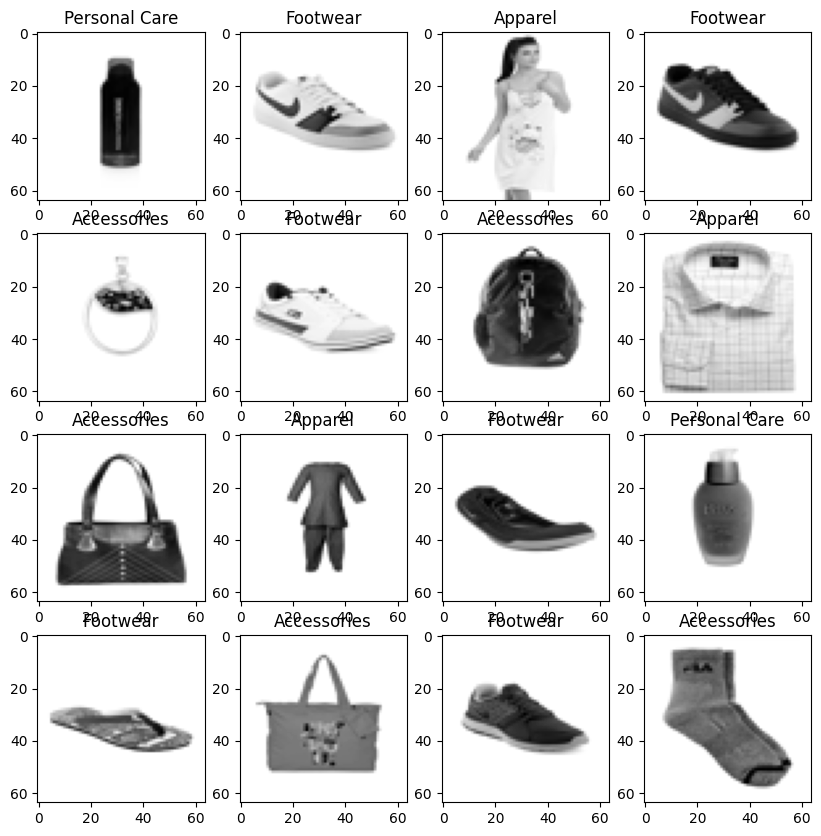

In [12]:
# split into train , validate and test 
x_main, x_test, y_main, y_test = train_test_split(stylesImgs, stylesData['target'], test_size=0.1, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_main, y_main, test_size=0.2, random_state=42)
#prints the size of the image as it is an important input when building the model and these values are present in SCALING_SIZE constant above 
print(f"Image size is {x_train[0].shape}")
#this plot draws a sample of the images and add thier label to them
fig, axes = plt.subplots(4, 4, figsize=(10, 10))
for idx,(i,j,ax) in enumerate(zip(x_train, y_train.values,axes.flatten())):
    if idx == 16:
        break
    ax.imshow(i,cmap='gray')
    ax.set_title(decoder_dict.get(j))

# **Creating our (**CNN**)**

In [13]:
#fpc stands for fashion Product Classification#

#Sequential CNN model.
fpcModel= tf.keras.Sequential()
# two layers for condensing the input and getting features from it using convolutional neuron with relu activation function and max pooling
fpcModel.add(layers.Conv2D(filters = 64, kernel_size = (4,4), activation = 'relu', input_shape = (SCALING_SIZE[0], SCALING_SIZE[1], 1)))
fpcModel.add(layers.BatchNormalization())
fpcModel.add(layers.MaxPool2D(pool_size = (2,2)))

fpcModel.add(layers.Conv2D(filters = 64, kernel_size = (4,4), activation = 'relu'))
fpcModel.add(layers.BatchNormalization())
fpcModel.add(layers.MaxPool2D(pool_size = (2,2)))
#this layer for updating some inputs each epoch which prevent over fitting
fpcModel.add(layers.Dropout(0.2))
#reduces the network to the output neuron which we use a softmax activation function on it to make us able to get the classification output
fpcModel.add(layers.Flatten())
fpcModel.add(layers.Dense(NUMBER_UNIQUE_CATEGORY, activation = 'softmax'))
#compiling the CNN model using the adam optimizer and getting the loss and the accuracy as these are the metrics that are important to us
fpcModel.compile(optimizer='adam',
              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics = ['accuracy'])
fpcModel.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 61, 61, 64)     │         1,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 61, 61, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 27, 27, 64)     │        65,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 27, 27, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 13, 13, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 13, 13, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 10816)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 7)              │        75,719 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 142,919 (558.28 KB)

 Trainable params: 142,663 (557.28 KB)

 Non-trainable params: 256 (1.00 KB)

# **Model training and validation**

In [14]:
#fitting our model with the data I had processed in the notebook through 20 epochs of training and validation
fpcModel.fit(
    np.array(x_train).reshape(-1, SCALING_SIZE[0], SCALING_SIZE[1], 1),
    y_train,
    epochs = 20,
    validation_data=(np.array(x_val).reshape(-1, SCALING_SIZE[0], SCALING_SIZE[1], 1), y_val)
)

Epoch 1/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 262s 260ms/step - accuracy: 0.8980 - loss: 0.5040 - val_accuracy: 0.5259 - val_loss: 3.6398
Epoch 2/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 256s 254ms/step - accuracy: 0.9506 - loss: 0.2542 - val_accuracy: 0.8933 - val_loss: 0.6609
Epoch 3/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 253s 253ms/step - accuracy: 0.9645 - loss: 0.1803 - val_accuracy: 0.7798 - val_loss: 1.6611
Epoch 4/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 277s 268ms/step - accuracy: 0.9680 - loss: 0.1470 - val_accuracy: 0.6363 - val_loss: 2.0612
Epoch 5/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 258s 258ms/step - accuracy: 0.9759 - loss: 0.1024 - val_accuracy: 0.9417 - val_loss: 0.3157
Epoch 6/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 265s 262ms/step - accuracy: 0.9798 - loss: 0.0794 - val_accuracy: 0.9475 - val_loss: 0.2563
Epoch 7/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 257s 257ms/step - accuracy: 0.9811 - loss: 0.0702 - val_accuracy: 0.9551 - val_loss: 0.2423
Epoch 8/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 258s 258ms/step - ac

# **Testing our CNN model and getting it's accuracy**

In [15]:
#we test the our model and see the final accuracy of it over the test dataset
test_loss, test_acc = fpcModel.evaluate(np.array(x_test).reshape(-1, SCALING_SIZE[0], SCALING_SIZE[1], 1), y_test, verbose = 2)
print(f"\n Test accuracy: { test_acc * 100 }%")

139/139 - 6s - 42ms/step - accuracy: 0.9775 - loss: 0.1451

 Test accuracy: 97.74876236915588%
